# About the Data

* The data was taken from 
the csv file complaints.csv


* The complaints are for the products:<br>

  1. 'Bank account or service'
  2. 'Checking or savings account'
  3. 'Consumer Loan'
  4. 'Credit card or prepaid card'
  5. 'Credit reporting, credit repair services, or other personal consumer reports' 
  6. 'Debt collection'
  7. Money transfer/s, virtual currency, or money service'
  8. 'Mortgage'
  9. 'Payday loan, title loan, or personal loan'
  10. 'Student loan'
  11. 'Vehicle loan or lease'


* The data cleaning and stopwords removal was done using the spacy library

* The sample data that has at most 10 percent 'MASK' words. 




# Fine Tuning DistilBERT model for text classification

* The model was trained on 3 epochs and the learning rate was set at 2e-5

* Data Split:<br>
      -Training data: 30769 (72 percent)
      -Validation data: 7693 (18 percent)
      -Test Data : 4274 (10 percent)

* F1-score<br>
      -Training data: 0.71
      -Validation data: 0.66
      -Testing Data: 0.55
  

* Fine-tuning was done on the sample data of size 42736 entries that has at most 10 percent 'MASK' words. 

* In the test data out of 4274 entries 3113 entries [labels with highest prediction scores] were predicted correctly by the DistilBERT model (72.8 percent). In the remaining 1161 wrongly predicted classes, 592 entries were predicted with the second highest prediction scores by the DistilBERT model ( About 86 percent of the data was predicted within the first and second highest prediction scores). Out of the remaining 569 predictions, 229 entries were predicted with the third highest prediction scores by the DistilBERT model (About 92 percentage of the data was predicted within the first, second and third highest prediction scores).
   

##Google Drive access

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Path

In [ ]:
# write the appropriate paths to retrieve the data and store results 
user_path = '/content/drive/MyDrive/Complaints_csv/Experiment5/'
best_model_path = user_path + "best_model.pt"
used_test_data_path = user_path + "Test_data_DistilBERT.csv"
label2id_df_path = user_path + "label2id_df.csv"

## Set-up environment

Install the libraries HuggingFace Transformers and Datasets

In [ ]:
#Install HuggingFace tranformer and datasets libraries  
!pip install -q transformers datasets 

     |████████████████████████████████| 4.0 MB 4.7 MB/s 
     |████████████████████████████████| 325 kB 41.5 MB/s 
     |████████████████████████████████| 596 kB 47.3 MB/s 
     |████████████████████████████████| 895 kB 44.9 MB/s 
     |████████████████████████████████| 6.6 MB 32.1 MB/s 
     |████████████████████████████████| 77 kB 5.0 MB/s 
     |████████████████████████████████| 1.1 MB 35.4 MB/s 
     |████████████████████████████████| 212 kB 41.8 MB/s 
     |████████████████████████████████| 136 kB 39.3 MB/s 
     |████████████████████████████████| 127 kB 46.1 MB/s 
     |████████████████████████████████| 94 kB 2.7 MB/s 
     |████████████████████████████████| 144 kB 37.5 MB/s 
     |████████████████████████████████| 271 kB 44.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which i

In [ ]:
##################################
#Import the librarires
##################################

# Core packages for text processing.

import string
import re

# Libraries for text preprocessing.

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import spacy


import torch
import transformers
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import logging
from transformers import AutoModelForSequenceClassification
from torch.optim import AdamW 
from transformers import pipeline
import pandas as pd


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#Check if GPU is available

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device, "is available")

cpu is available


## Loading the Dataset

In [ ]:
#Load the data
import pandas as pd
test_data_df = pd.read_csv(used_test_data_path)
test_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4274 entries, 0 to 4273
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  4274 non-null   object
 1   label     4274 non-null   object
dtypes: object(2)
memory usage: 66.9+ KB


Let's create a list that contains the labels, as well as 2 dictionaries that map labels to integers and back.

In [ ]:
labels2id_df = pd.read_csv(label2id_df_path)
labels2id_df

,Bank account or service,Checking or savings account,Consumer Loan,Credit card or prepaid card,"Credit reporting, credit repair services, or other personal consumer reports",Debt collection,"Money transfer/s, virtual currency, or money service",Mortgage,"Payday loan, title loan, or personal loan",Student loan,Vehicle loan or lease
0,0,1,2,3,4,5,6,7,8,9,10


In [ ]:
labels = labels2id_df.columns.to_list()
ids = [int(i) for i in labels2id_df.loc[0,:]]
id2label = {A: B for A, B in zip(ids, labels)} 
label2id = {A: B for A, B in zip(labels,ids)} 
labels = list(labels)

The dataset consists of 11 topics.

## Data Cleaning

In [ ]:
stop = set(stopwords.words('english'))
def text_pre_process(text,stop):

  """
  text: the user-typed input text
  the function text_pre_process outputs change_text that is the pre-processed text
  """
  # Some basic helper functions to clean text by removing urls, emojis, html tags and punctuations.

  def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

  def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
  
  def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

  def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

  # Applying helper functions

  text_clean = remove_URL(text)
  text_clean = remove_emoji(text_clean)
  text_clean =  remove_html(text_clean)
  text_clean =  remove_punct(text_clean)

  # Tokenizing 'text_clean'

  tokenized_data = word_tokenize(text_clean)

  # Lower casing 'tokenized_data'

  lower_text = [word.lower() for word in tokenized_data]

  # Removing stopwords 

  stop_words_removed= [word for word in lower_text if word not in stop]

  # Applying part of speech tags

  pos_tags_text =  nltk.tag.pos_tag(stop_words_removed)

  # Converting part of speeches to wordnet format.

  def get_wordnet_pos(tag):
    if tag.startswith('J'):
      return wordnet.ADJ
    elif tag.startswith('V'):
      return wordnet.VERB
    elif tag.startswith('N'):
      return wordnet.NOUN
    elif tag.startswith('R'):
      return wordnet.ADV
    else:
      return wordnet.NOUN

  wordnet_pos_text = [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in pos_tags_text ]

  # Applying word lemmatizer.

  wnl = WordNetLemmatizer()

  lemmatized_text = [wnl.lemmatize(word, tag) for word, tag in wordnet_pos_text]

  lemmatized_text = [word for word in lemmatized_text  if word not in stop]
  lemma_str = str(' '.join(lemmatized_text))

  ##################################
  #Define the strings to mask
  ##################################
  mask_words_list =['XX/XX/XXXX','XX-XX-XXXX', #DATE mm/dd/yyyy mm-dd-yyyy
            'XXXX XXXX XXXX XXXX XXXX','XXXX-XXXX-XXXX-XXXX',#CREDIT or PREPAID CARD NUMBER
            'XXXX XXXX XXXX XXXX','XXXX XXXX XXXX','XXXX-XXXX-XXXX','XXXX-XXXX','XXXX XXXX',
            'XXX-XX-XXXX','XXX-XXX','XX-XXXX',
            'XXXXXXXXXXXXXXXXXX','XXXXXXXXXXXXXXXXX', 'XXXXXXXXXXXXXXXX', 'XXXXXXXXXXXXXXX', 'XXXXXXXXXXXXXX',# BANK ACCOUNT NUMBER
            'XXXXXXXXXXXXX', 'XXXXXXXXXXXX', 'XXXXXXXXXXX',                                                   # RANGES FROM 12 TO 18 DIGITS
            'XXXXXXXXXX','XXXXXXXXX'          #ROUTING NUMBER IS 9 DIGIT
            'XXXX','XXX','XX']


  mask_words_list_lower =[mask_word.lower() for mask_word in mask_words_list]

  ##################################
  #Create Spacy Doc
  ##################################
  spacy_nlp = spacy.load("en_core_web_sm")
  text_doc = spacy_nlp(lemma_str)

  # Function to identify the tokens and named entities that have to be MASKED replace them with ' <MASK> '   
  def change_details(word,mask_words_list,mask_words_list_lower):
    """
    word: is the word contained in the text_doc
    the function change_details outputs string depending on the type of the word
    """
    if word.like_email or word.like_url:
      return '<MASK>'
    elif any(mask_word in word.string for mask_word in mask_words_list):
      return '<MASK>'
    elif word.is_stop:
      return ''
    elif (len(re.findall('\.',word.string)) < 1) :
      if word.is_punct:
        return ''
    return word.string

    # Function where each token of spacy doc is passed through change_details()
  def change_text(doc):
    """
    doc: is the spacy document of the corresponding text
    the function change_text returns the preprocessed string
    """
    bert_threshold = 230
    # Passing each token through change_details() function.
    new_tokens = map(change_details,doc,mask_words_list,mask_words_list_lower)
    
    new_text = str(' '.join(new_tokens))
    # replace more than one white space in the string with one white space
    new_text = re.sub(' +', ' ',new_text)
    new_text = new_text.replace(' .', '.')
    new_text = new_text.replace('\n', '')
    new_text_words  = new_text.split()
    if len(new_text_words) < bert_threshold:
      return new_text
    else :
      truncated_text_words  = new_text_words[:bert_threshold]
      truncated_text = str( " ".join(truncated_text_words))
      return truncated_text


  changed_text = change_text(text_doc)
  return changed_text

Example

In [ ]:
test_data_df.loc[0,'sentence']

'hello recently account capital bank close decision continue business relationship try numerous time request fund little 28000000 able detail receive fund believe bank steal money communicate regard repeat request receive fund like matter investigate prosecute extent law bank close account hold money hostage'

In [ ]:
text_pre_process(test_data_df.loc[0,'sentence'],stop)

'hello recently <MASK> capital <MASK> <MASK> decision continue <MASK> relationship try numerous time request fund little 28000000 able detail receive fund believe bank steal '

#Changed Text

In [ ]:
from tqdm import tqdm
# instantiate
tqdm.pandas()
test_data_df['masked_lemma_str']= test_data_df['sentence'].progress_apply(lambda x: text_pre_process(x,stop))
print("\n\nText Transformation Completed")

100%|██████████| 4274/4274 [49:16<00:00,  1.45it/s]



Text Transformation Completed


In [ ]:
test_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4274 entries, 0 to 4273
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   sentence          4274 non-null   object
 1   label             4274 non-null   object
 2   masked_lemma_str  4274 non-null   object
dtypes: object(3)
memory usage: 100.3+ KB


In [ ]:
test_data_df.to_csv(user_path+'Test_data_cleaned.csv', index=False)

In [ ]:
test_data_df =test_data_df.loc[:,['masked_lemma_str','label']]
test_data_df.rename(columns = {'masked_lemma_str':'sentence'},inplace=True)
test_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4274 entries, 0 to 4273
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  4274 non-null   object
 1   label     4274 non-null   object
dtypes: object(2)
memory usage: 66.9+ KB


In [ ]:
from datasets import Dataset
test_dataset = Dataset.from_pandas(test_data_df)
test_dataset

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4274
})

## Preprocess data


Since the model don't expect text as direct input, but rather `input_ids`, etc., we tokenize the text using the tokenizer. Here I'm using the `AutoTokenizer` API, which will automatically load the appropriate tokenizer based on the checkpoint on the hub.

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-cased',num_labels=len(labels))

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [ ]:
import numpy as np
def preprocess_data(examples):
    # take a batch of texts
    text = examples["sentence"]
    # encode them
    encoding = tokenizer(text, padding="max_length", truncation=True)
    return encoding

In [ ]:
encoded_test_dataset = test_dataset.map(preprocess_data, batched=True, remove_columns= ['sentence','label'])

  0%|          | 0/5 [00:00<?, ?ba/s]

In [ ]:
encoded_test_dataset 

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 4274
})

In [ ]:
example = encoded_test_dataset[0]
print(example.keys())

dict_keys(['input_ids', 'attention_mask'])


In [ ]:
tokenizer.decode(example['input_ids'])

'[CLS] hello recently < MASK > capital < MASK > < MASK > decision continue < MASK > relationship try numerous time request fund little 28000000 able detail receive fund believe bank steal [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [ ]:
encoded_test_dataset

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 4274
})

In [ ]:
encoded_test_dataset.set_format("torch")

## Load the best model

Loading Function.

**load_chkp** is created for loading model. 

It takes:
*   location of the saved checkpoint
*   model instance that you want to load the state to
*   the optimizer

In [ ]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath,map_location=torch.device('cpu'))
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min



## Define model

Here we define a model that includes a pre-trained base (i.e. the weights from the distilbert-base-cased) are loaded, with a random initialized classification head (linear layer) on top. One should fine-tune this head, together with the pre-trained base on a labeled dataset.

In [ ]:
from transformers import AutoModelForSequenceClassification 

model_best = AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)
model_best.to(device)

Downloading:   0%|          | 0.00/251M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bia

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [ ]:
#Set the parameters

fixed_learning_rate = 1e-5
fixed_batch_size = 16

Load the optimizer

In [ ]:
#Optimizer
from torch.optim import AdamW 
optimizer_best = AdamW(model_best.parameters(),lr = fixed_learning_rate)

In [ ]:
# load the saved checkpoint
model_best, optimizer_best, end_epoch, valid_loss_min = load_ckp(best_model_path, model_best, optimizer_best)

## Predicting the test set

In [ ]:
#DataLoader
from torch.utils.data import DataLoader
test_dataloader = DataLoader(encoded_test_dataset, batch_size = fixed_batch_size)

Create a function for formatting elapsed times as hh:mm:ss

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import time
total_t0 = time.time()
model_best.eval()

predictions=[]
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model_best(**batch)
    test_logits = outputs.logits
    test_prediction = torch.argmax(test_logits, dim=-1).detach().cpu().numpy()
    predictions.append(test_prediction)

total_testing_time = time.time() - total_t0    
print("\nTotal testing time taken: {:} (h:mm:ss)".format(format_time(total_testing_time)))




Total testing time taken: 1:04:28 (h:mm:ss)


In [ ]:
full_predictions = np.concatenate(predictions)
true_labels = test_data_df["label"].map(label2id).values

In [ ]:
# Function to calculate the accuracy, precision, recall, F-measure  of our predictions vs labels
from sklearn.metrics import precision_recall_fscore_support

def multi_class_metric(labels,preds):
    pred_flat = preds.flatten()
    labels_flat = labels.flatten()
    accuracy = np.sum(pred_flat == labels_flat) / len(labels_flat)
    precision_macro, recall_macro, f1_macro_average,_ = precision_recall_fscore_support(labels,preds,average='macro',zero_division = 0)
    # return as dictionary
    metrics = {
               'f1': f1_macro_average,
               'accuracy': accuracy,
               'precision': precision_macro,
               'recall': recall_macro
               }
    return metrics


In [ ]:
test_metrics = multi_class_metric(true_labels ,full_predictions )
print("\nThe metrics in the test data are: \n")

test_metric_df = pd.DataFrame([test_metrics], columns =test_metrics.keys(), index= ['value']).T
display(test_metric_df)


The metrics in the test data are: 



,value
f1,0.557702
accuracy,0.728358
precision,0.592547
recall,0.551569


The confusion matrix is : 



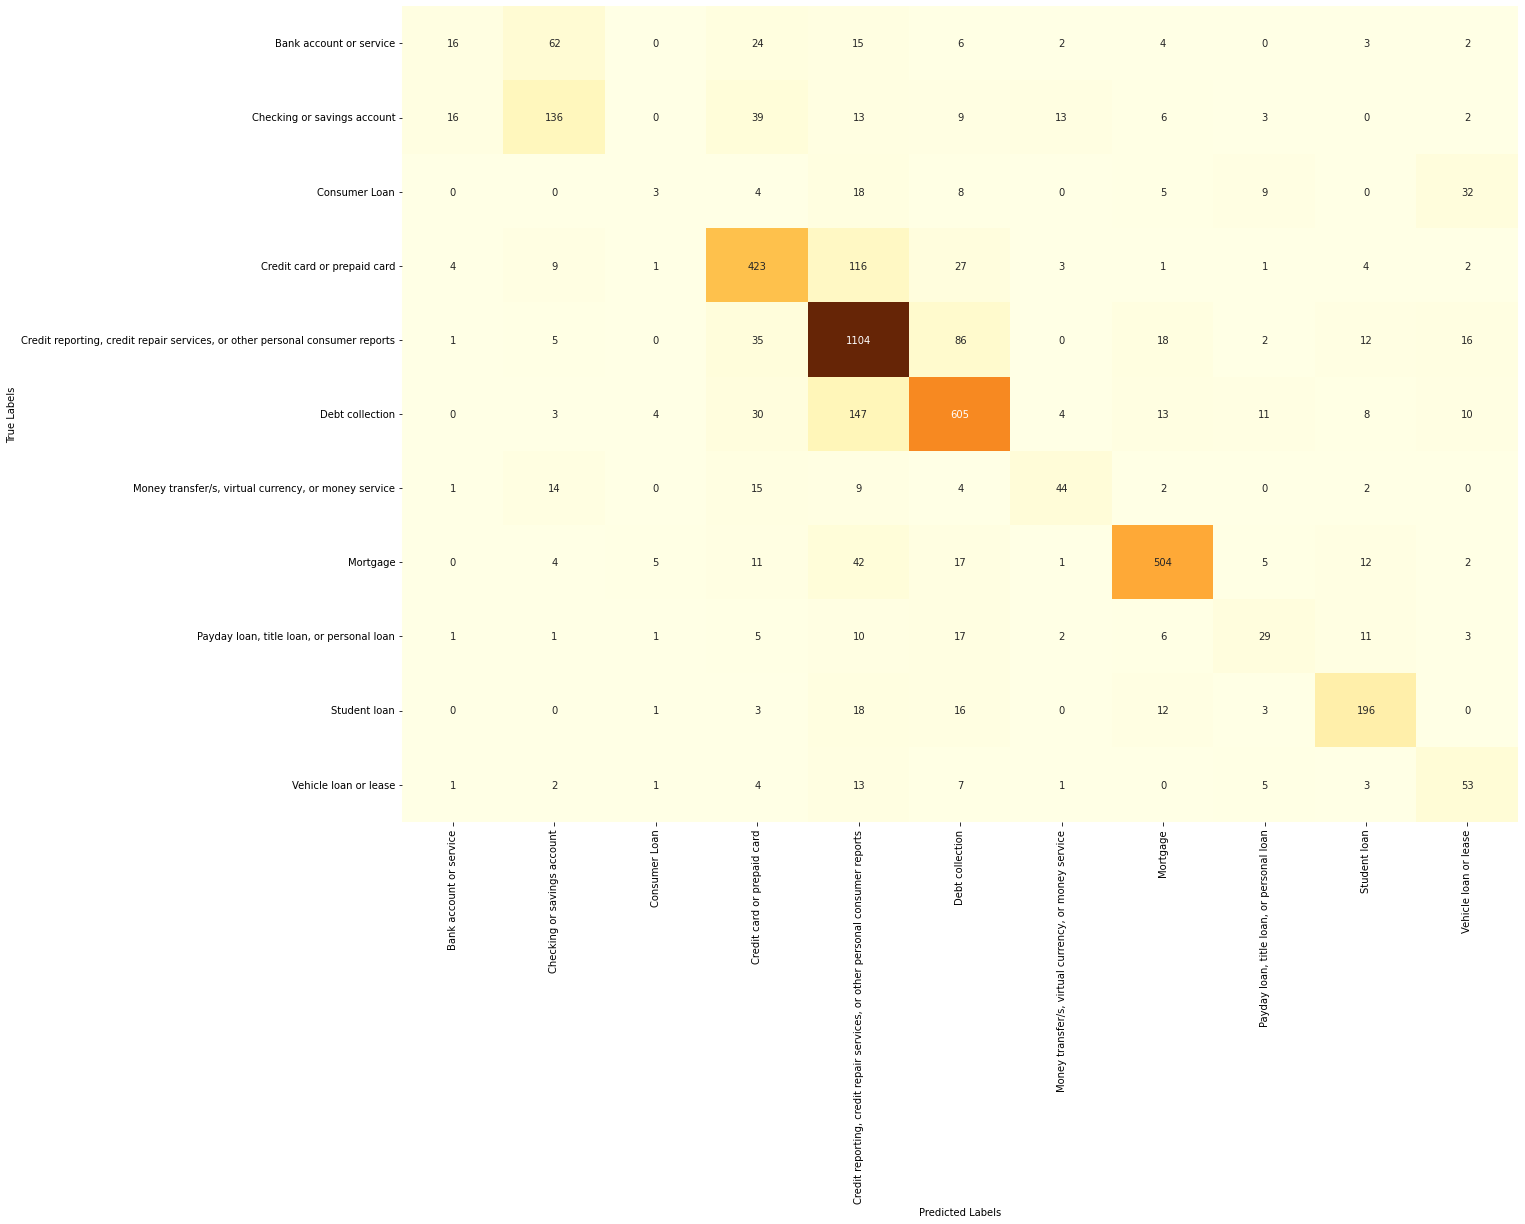

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
True_labels = test_data_df["label"].to_list() 
Predicted_labels = [id2label[i] for i in full_predictions]
cm = confusion_matrix(True_labels, Predicted_labels)
#plot the confusion matrix
print("The confusion matrix is : \n")
plt.figure(figsize=(20,15))
ax =sns.heatmap(cm, annot=True, fmt='d',cbar=False,xticklabels=labels, yticklabels=labels,cmap="YlOrBr")
ax.set(xlabel='Predicted Labels', ylabel='True Labels')
plt.show()

# Inference on the Test data 

In [ ]:
if device == 'cuda:0':
  device_value = 0
else:
  device_value =-1

#Create the DistilBERT pipeline
distilbert_nlp = pipeline(task="sentiment-analysis", return_all_scores = True, model=model_best, tokenizer=tokenizer,device= device_value)

In [ ]:
labels_rank_list=[]
labels_score_list=[]
def get_rank(example,fix_rank = 3):
  result_value = distilbert_nlp(example)
  sorted_value = sorted(result_value[0], key=lambda k: k['score'],reverse = True)
  new_dictionary_label = {'predicted_label_' + str(i+1): sorted_value[i]['label'] for i in range(fix_rank)}
  new_dictionary_score = {'predicted_score_' + str(i+1): sorted_value[i]['score'] for i in range(fix_rank)}
  labels_rank_list.append(new_dictionary_label)
  labels_score_list.append(new_dictionary_score)

In [ ]:
from tqdm import tqdm
# instantiate
tqdm.pandas()
get_result = test_data_df['sentence'].progress_apply(lambda row : get_rank(row,fix_rank = 3))


100%|██████████| 4274/4274 [07:43<00:00,  9.22it/s]


In [ ]:
list2d_rank = {key: [i[key] for i in labels_rank_list] for key in labels_rank_list[0]}
list2d_score = {key: [i[key] for i in labels_score_list] for key in labels_score_list[0]}

In [ ]:
predicted_dataframe = pd.concat([test_data_df,pd.DataFrame(list2d_rank),pd.DataFrame(list2d_score)], axis=1)
predicted_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4274 entries, 0 to 4273
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sentence  4274 non-null   object 
 1   label     4274 non-null   object 
 2   label_1   4274 non-null   object 
 3   label_2   4274 non-null   object 
 4   label_3   4274 non-null   object 
 5   score_1   4274 non-null   float64
 6   score_2   4274 non-null   float64
 7   score_3   4274 non-null   float64
dtypes: float64(3), object(5)
memory usage: 267.2+ KB


In [ ]:
#Check if the first predicted label is the true label {1: the first predicted label is the true label,0: the first predicted label is not the true label}
predicted_dataframe['First_prediction']=  (predicted_dataframe['label'] == predicted_dataframe['label_1'])
predicted_dataframe['First_prediction']= predicted_dataframe['First_prediction'].astype(int)
predicted_dataframe['First_prediction'].value_counts().sort_index()

0    1161
1    3113
Name: First_prediction, dtype: int64

In [ ]:
#Check if the second predicted label is the true label{1: the second predicted label is the true label,0: the second predicted label is not the true label}
predicted_dataframe['Second_prediction']=  (predicted_dataframe['label'] == predicted_dataframe['label_2'])
predicted_dataframe['Second_prediction']= predicted_dataframe['Second_prediction'].astype(int)
predicted_dataframe['Second_prediction'].value_counts().sort_index()

0    3682
1     592
Name: Second_prediction, dtype: int64

In [ ]:
#Check if the third predicted label is the true label {1: the third predicted label is the true label,0: the third predicted label is not the true label}
predicted_dataframe['Third_prediction']=  (predicted_dataframe['label'] == predicted_dataframe['label_3'])
predicted_dataframe['Third_prediction']= predicted_dataframe['Third_prediction'].astype(int)
predicted_dataframe['Third_prediction'].value_counts().sort_index()

0    4045
1     229
Name: Third_prediction, dtype: int64

In [ ]:
#Frequency count to check the number of True labels in the first three predictions out of 4274 test data entries
predicted_dataframe.loc[:,['First_prediction','Second_prediction','Third_prediction']].sum()

First_prediction     3113
Second_prediction     592
Third_prediction      229
dtype: int64

In [ ]:
#Number of total correct predictions made by the DistilBERT model within the highest and second highest prediction score
predicted_dataframe.loc[:,['First_prediction','Second_prediction']].sum().sum()

3705

In [ ]:
#Percentage of correct predictions made by the DistilBERT model within the highest and second highest prediction score
predicted_dataframe.loc[:,['First_prediction','Second_prediction']].sum().sum()/predicted_dataframe.shape[0]

0.8668694431445952

In [ ]:
#Number of total correct predictions made by the DistilBERT model within the highest,second highest and third highest prediction score
predicted_dataframe.loc[:,['First_prediction','Second_prediction','Third_prediction']].sum().sum()

3934

In [ ]:
#Percentage of correct predictions made by the DistilBERT model within the highest,second highest and third highest prediction score
predicted_dataframe.loc[:,['First_prediction','Second_prediction','Third_prediction']].sum().sum()/predicted_dataframe.shape[0]

0.9204492278895648

Check if there are any incorrect predicitions and display a data frame of incorrect predictions if there exist one

In [ ]:
if Predicted_labels != True_labels:
    test_sentences = test_data_df['sentence']
    test_df=pd.DataFrame(test_sentences, columns=["sentence"])
    test_df['predicted_label']= Predicted_labels
    test_df['true_label']= True_labels
    pd.set_option('display.max_colwidth', None)
    display(test_df[test_df['predicted_label'] != test_df['true_label']])

,sentence,predicted_label,true_label
2,send email <MASK> loan <MASK> <MASK> promptly tell <MASK> early let system payment time prior early payment problem talk supervisor work home system nt,Mortgage,"Payday loan, title loan, or personal loan"
4,creditor executive <MASK> letter <MASK> <MASK> germane identity <MASK> ask extension payment arrangement deferment applicable hardship program ease payment past andor late fee account,"Credit reporting, credit repair services, or other personal consumer reports",Checking or savings account
14,capital financial <MASK> award <MASK> <MASK> 430000 unpaid <MASK> card account time freeze joint bank account spouse subsequently release capital attempt garnish wage time,Credit card or prepaid card,Debt collection
18,year receive <MASK> account <MASK> <MASK> account resolution <MASK> notification knowledge dispute account remove credit report past account place credit report warningnotification receive type,"Credit reporting, credit repair services, or other personal consumer reports",Debt collection
23,know help <MASK> mother <MASK> <MASK> action suit <MASK> settlement type company year ago sign debt settlement company thing remember money month account settle,Debt collection,"Money transfer/s, virtual currency, or money service"
...,...,...,...
4241,receive 3 <MASK> message <MASK> <MASK> know trouble <MASK> bank check clear transfer bank bank release fund check clear bank holiday extra day unfortunately,"Money transfer/s, virtual currency, or money service",Vehicle loan or lease
4248,dispute charge <MASK> loan <MASK> <MASK> resolve issue <MASK> pennsylvania statute limitation year typical debt year credit card debt contractual loan obligation creditor long,Debt collection,"Credit reporting, credit repair services, or other personal consumer reports"
4253,prior servicer <MASK> 90000000 <MASK> <MASK> federal income <MASK> withhold internal revenue service figure typical mortgage nt purport start claim security interest highly suspect,Mortgage,Debt collection
4254,heavy medication <MASK> par <MASK> <MASK> year ago <MASK> sign county judge judgement favor 130000 shock aware court appointment knowledge 46 month receive letter,"Credit reporting, credit repair services, or other personal consumer reports",Debt collection


## Download

In [ ]:
test_data_second_predictions = predicted_dataframe.query('Second_prediction == 1')
test_data_second_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 592 entries, 14 to 4254
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sentence           592 non-null    object 
 1   label              592 non-null    object 
 2   label_1            592 non-null    object 
 3   label_2            592 non-null    object 
 4   label_3            592 non-null    object 
 5   score_1            592 non-null    float64
 6   score_2            592 non-null    float64
 7   score_3            592 non-null    float64
 8   First_prediction   592 non-null    int64  
 9   Second_prediction  592 non-null    int64  
 10  Third_prediction   592 non-null    int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 55.5+ KB


In [ ]:
test_data_second_predictions.to_csv(user_path + 'test_data_second_predictions.csv',encoding='utf-8', index=False)
print("\n\nDownload Completed")



Download Completed
